# hexapod 

# 1st excersise - calculate orientaiton and position 



In [99]:
from enum import verify
from tabnanny import verbose
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt



# base config


In [100]:
from unittest.mock import Base

# SI units
actuator_min_leangth = 0.5
actuator_max_leangth = 0.8
Actuator_leangths = np.array([0.5,0.5,0.5,0.5,0.5,0.5])

Actuator_connection_base_distance = 0.3
Actuator_connection_top_distance = 0.2
Short_edge_deg = 20

Base_hexagon = np.zeros((6,3))

cg_above_top = np.array([0,0,0.5])
mass = 20 #kg







# Sample confguration of both bases


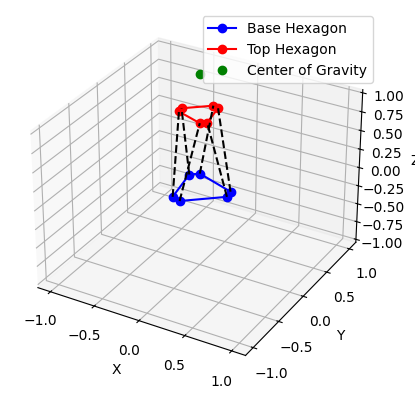

In [101]:

  
def Odd_heaxagon_base_3d(inner_edge_leangth, short_edge_deg, height):
    hexagon = np.zeros((6,3))
    angles = np.zeros(6)
    for i in range(6):
      short_angle = np.deg2rad(short_edge_deg)
      angle = np.deg2rad(120) - short_angle
      if i%2 == 0:
          angles[i] = angles[i-1]+short_angle
      else:
          angles[i] = angles[i-1]+angle
            
      hexagon[i] = [inner_edge_leangth*np.cos(angles[i]), inner_edge_leangth*np.sin(angles[i]), height]
    
    return hexagon
 
#numpy 60 deg roation matrix around z axis
def rotz(theta):
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])
    return R
  
base_Translation = Odd_heaxagon_base_3d(Actuator_connection_base_distance,Short_edge_deg,0)
top_base_Translation = Odd_heaxagon_base_3d(Actuator_connection_top_distance,Short_edge_deg,1)


top_base_Translation = np.dot(top_base_Translation, rotz(np.deg2rad(60)))



# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot base hexagon
ax.plot(base_Translation[:, 0], base_Translation[:, 1], base_Translation[:, 2], 'bo-', label='Base Hexagon')

# Plot top hexagon
ax.plot(top_base_Translation[:, 0], top_base_Translation[:, 1], top_base_Translation[:, 2], 'ro-', label='Top Hexagon')

# Connect corresponding vertices of base and top hexagons
for i in range(6):
    ax.plot([base_Translation[i-1, 0], top_base_Translation[i, 0]],
            [base_Translation[i-1, 1], top_base_Translation[i, 1]],
            [base_Translation[i-1, 2], top_base_Translation[i, 2]], 'k--')

# plot center of gravity
ax.plot([cg_above_top[0]], [cg_above_top[1]], top_base_Translation[0, 2]+[cg_above_top[2]], 'go', label='Center of Gravity')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Equal aspect ratio
minbound = -1
maxbound = 1
ax.auto_scale_xyz([minbound, maxbound], [minbound, maxbound], [minbound, maxbound])

plt.show()



#


# Load calculation


All moments on each support = 0

F = F


In [133]:
from email.mime import base
import numpy as np
import scipy.optimize as opt

# Actuator load in 3D (2D matrix)

# Actuator loads is the variable to be solved
def moment_force_equalibrium_equation(actuator_loads, base_plate, force, cg_of_force_relative):
    support_count = len(base_plate)
    actuator_loads = actuator_loads.reshape((support_count, 3))
    
    
    translation_result = np.zeros(3) - force
    for support_index in range(support_count):
        translation_result += actuator_loads[support_index]
    
    
    # around n-1 actuators
    moment_result = np.zeros((support_count-1, 3))
    for i in range(support_count-1):
      moment_result[i] = -np.cross(cg_of_force_relative-base_plate[i], force)
      for ii in range(support_count):
        moment_result[i] += np.cross(base_plate[ii]-base_plate[i], actuator_loads[ii])
        
    result = np.concatenate((translation_result, moment_result))

    # add extra needed 0 to match the shape of incoming actuator loads size
    # diff = len(actuator_loads.flatten()) - len(result)
    # result = np.concatenate((result, np.zeros(diff)))
    
    return result

def get_actuator_loads(base_plate, top_plate, cg_relative_to_top_plate, mass):
    # Assume the base plate is not rotated, only y forces 
    support_count = len(base_plate)
    actuator_loads = np.zeros((support_count, 3))
    payload_force = np.array([0, 0, -mass * 9.81])
    
    actuator_loads = opt.fsolve(moment_force_equalibrium_equation, actuator_loads.flatten(), args=(base_plate, payload_force, cg_relative_to_top_plate[:3]), xtol=1e-10, full_output=True)
    
    actuator_loads = actuator_loads[0]
    actuator_loads = actuator_loads.reshape((support_count, 3))
    rounded_actuator_loads = np.round(actuator_loads, 1)
    return rounded_actuator_loads


result = get_actuator_loads(base_Translation, top_base_Translation, cg_above_top, mass)


verify = moment_force_equalibrium_equation(result, base_Translation, np.array([0, 0, -mass * 9.81]), cg_above_top[:3])
if np.allclose(verify, 0, atol=1e-3):
    print("Solution verified")
else:
    print("Solution not verified")
    # print the error
    print(verify)

# Plotting
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Plot force vectors at each base plate from base_Translation 
for i in range(6):
    ax.quiver(base_Translation[i, 0], base_Translation[i, 1], base_Translation[i, 2],
              result[i, 0], result[i, 1], result[i,2], color='r')


# add identifier for each force vector
for i in range(6):
    ax.text(base_Translation[i, 0], base_Translation[i, 1], base_Translation[i, 2],
            f'F{i+1}', color='r')

# Equal aspect ratio



# make a 2d plot of the forces
fig = plt.figure()
ax = fig.add_subplot(111)
ax.quiver(base_Translation[:, 0], base_Translation[:, 1], result[:, 0], result[:, 1], color='r')
for i in range(6):
    ax.text(base_Translation[i, 0], base_Translation[i, 1], f'F{i+1}', color='r') 
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
minbound = -0.5
maxbound = 0.5

# corrct scale
ax.set_xlim([minbound, maxbound])
ax.set_ylim([minbound, maxbound])

plt.show()
#

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)